# Recurrent neural network

__Author:__ John Leung

__Content:__ This program demonstrates the tasks of natural language processing and sequence sampling using recurrent neural networks (RNNs) in the keras framework. In particular, we construct our many-to-many RNN using networks of Long Short Term Memory (LSTM) blocks.

In the first part of the program, we translate a human style written date format to a standardized format (yyyy-mm-dd). The model we use is an RNN with attention. we use is as follow: First we decode the human written date using a bi-directional LSTM (Bi-LSTM). The information decoded by this pre-attention Bi-LSTM is then passed onto the attention layer. The attention layer consists of units of neurons. Finally, its output is read by another (post-attention) LSTM to generate an output sequence of our desired date format. The important feature of this attention network is that the output sequence is of a length different from the input sequence.

In the second part of the program, we synthesize music by sampling a trained RNN. We first train a LSTM RNN to identify snippets of musical notes, such that an input of musical note x(t) outputs a prediction of the next note y=x(t+1). After training the model, we intialize the trained RNN by a random/zero input x(t=0). Then at every times step we fit the LSTM input with the previous time step x(t)=y(t-1). This way we sample the model and synthesize a new sequence using only the model and a single initialization time step as inputs.

This program is inspired by and use data source from the course on [Sequence Models](https://www.coursera.org/learn/nlp-sequence-models) provided by __deeplearning.ai__ on __Coursera__.

In [3]:
# -*- coding: utf-8 -*-

from __future__ import print_function

import IPython
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda, Dropout, Reshape
from keras.optimizers import Adam
from keras.initializers import glorot_uniform
from keras.utils import to_categorical
from keras.models import load_model, Model
import keras.backend as K
import numpy as np
from tqdm import tqdm_notebook

from faker import Faker
from music21 import *
import random
from tqdm import tqdm
from babel.dates import format_date
from nmt_utils import *
from grammar import *
from qa import *
from preprocess import * 
from music_utils import *
from data_utils import *
import matplotlib.pyplot as plt

import pandas as pd
import re
import nltk
import codecs

nltk_dir = '/Users/bbsonjohn/nltk_data'
data_dir = 'data/hansard.36/Release-2001.1a/sentence-pairs/house/debates/development/'
tknzr = nltk.tokenize.TweetTokenizer()
en_sentence_detector = nltk.data.load(nltk_dir + '/tokenizers/punkt/english.pickle')
fr_sentence_detector = nltk.data.load(nltk_dir + '/tokenizers/punkt/french.pickle')

%matplotlib inline

Using TensorFlow backend.
 
Music21 v.4 is the last version that will support Python 2.
Please start using Python 3 instead.

Set music21.environment.UserSettings()['warnings'] = 0
to disable this message.



In [4]:
read_length = 10000
num_len = 3; first_file = 1; last_file = 243
file_char_encoding = 'cp1252'

train_set = 'training/hansard.36.1.house.debates.'

sentence_sample = np.random.randint(read_length)

current_len = 0
en_text = []; fr_text = []
for file_no in range(first_file, last_file+1):
    filename_e = data_dir + train_set + str(file_no).zfill(num_len) + '.e'
    filename_f = data_dir + train_set + str(file_no).zfill(num_len) + '.f'
    f_en = codecs.open(filename_e, "r", encoding=file_char_encoding)
    f_fr = codecs.open(filename_f, "r", encoding=file_char_encoding)
    while True:
        line_e = f_en.readline()
        line_f = f_fr.readline()
        if (not line_e) or (not line_f): break
        en_text.append(line_e.encode('utf-8'))
        fr_text.append(line_f.encode('utf-8'))
        current_len = current_len + 1
        if current_len >= read_length:
            break
    f_en.close()
    f_fr.close()
    if current_len >= read_length:
            break
                       
en_text = map(lambda x:x.lower(),en_text)
fr_text = map(lambda x:x.lower(),fr_text)
print(en_text[sentence_sample])
print(fr_text[sentence_sample])

* * * 

* * * 



In [5]:
#en_sents = map(lambda x:en_sentence_detector.tokenize(x.strip()) , en_text )
#fr_sents = map(lambda x:fr_sentence_detector.tokenize(x.strip()) , fr_text )
en_token = []; fr_token = [];
for s in tqdm_notebook(en_text):
    en_token.append( tknzr.tokenize(s.strip()) )
for s in tqdm_notebook(fr_text):
    fr_token.append(tknzr.tokenize(s.strip()) )
    
del en_text; del fr_text;
    
print(en_token[sentence_sample])
print('\n')
print(fr_token[sentence_sample])


[u'*', u'*', u'*']


[u'*', u'*', u'*']


In [6]:
#https://pythonhealthcare.org/2018/12/20/108-converting-text-to-numbers/

def text_to_indices(text, cutoff_for_rare_words = 1):
    
    # Flatten list if sublists are present
    if len(text) > 1:
        flat_text = [item for sublist in text for item in sublist]
    else:
        flat_text = text
    
    # get word freuqncy
    fdist = nltk.FreqDist(flat_text)

    # Convert to Pandas dataframe
    df_fdist = pd.DataFrame.from_dict(fdist, orient='index')
    df_fdist.columns = ['Frequency']

    # Sort by word frequency
    df_fdist.sort_values(by=['Frequency'], ascending=False, inplace=True)

    # Add word index
    number_of_words = df_fdist.shape[0]
    df_fdist['word_index'] = list(np.arange(number_of_words)+1)

    # replace rare words with index zero
    frequency = df_fdist['Frequency'].values
    word_index = df_fdist['word_index'].values
    mask = frequency <= cutoff_for_rare_words
    word_index[mask] = 0
    df_fdist['word_index'] =  word_index
    
    # Convert pandas to dictionary
    word_dict = df_fdist['word_index'].to_dict()
    word_dict.update({u"<unk>":0})
    pad_num = max(word_dict.values()) + 1
    word_dict.update({u"<pad>":pad_num})
    reversed_dict = {value : key for (key, value) in word_dict.items()}
    reversed_dict.update({0:u"<unk>"})
    
    # Use dictionary to convert words in text to numbers
    text_numbers = []
    for string in text:
        string_numbers = [word_dict[word] for word in string]
        text_numbers.append(string_numbers)

    return word_dict, reversed_dict, text_numbers

In [7]:
en_2_ind, ind_2_en, en_indices = text_to_indices(en_token)
fr_2_ind, ind_2_fr, fr_indices = text_to_indices(fr_token)

print(en_indices[sentence_sample])
print(fr_indices[sentence_sample])

[45, 45, 45]
[47, 47, 47]


# Natural language processing - translating date format

In this section, our task is to translate between human-style date to machine style date.

First and foremost, we read in the data (X, Y). X contains strings of human written dates, and Y contains strings of fixed machine style dates: yyyy-mm-dd.

To achieve the goal of translation, we need a dictionary human_vocab (mapping to indices) that contains all the possible characters in the human style format, including the unknown character "<unk>" and padding for empty spaces "<pad>". We also need a dictionary (again mapping to indices) machine_vocab for the characters used by machine translation, which includes 11 characters from '0' to '9' and a hyphenation '-'. We also include the inverseinv_machine_vocab that maps indices back to characters.

## Preprocessing

We convert the data to one-hot representation. We also truncate the input (x) character to 30 characters. Strings longer 30 characters are thrown away and strings shorter than 30 characters are padded to 30 characters.

In [8]:
def preprocess((sents, inds), lang_2_ind, T):
    sents_ret = []; inds_ret = []; inds_ohs = [];
    i = 0;
    for sent in tqdm_notebook(sents):
        ind = inds[i]
        if len(sent) >= T:
            sent_redux = sent[0:T]
            ind_redux = ind[0:T]
        else:
            sent_redux = sent + ['<pad>'] * (T - len(sent))
            ind_redux = ind + [lang_2_ind['<pad>']] * (T - len(ind))
        ind_oh = np.zeros((T, max(lang_2_ind.values())+1 ))
        
        ind_oh[np.arange(T), ind_redux] = 1
        sents_ret.append(sent_redux)
        inds_ret.append(ind_redux)
        inds_ohs.append(ind_oh)
        i = i + 1
    return sents_ret, np.array(inds_ret), np.array(inds_ohs)

In [9]:
Tx = 30
Ty = 30

raw_X, X, Xoh = preprocess((fr_token, fr_indices), fr_2_ind, Tx)
del raw_X; del fr_indices; del fr_token;
raw_Y, Y, Yoh = preprocess((en_token, en_indices), en_2_ind, Ty)
del raw_Y; del en_indices; del en_token;

en_dict_size = max(en_2_ind.values())+1
fr_dict_size = max(fr_2_ind.values())+1


print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Xoh.shape:", Xoh.shape)
print("Yoh.shape:", Yoh.shape)


X.shape: (10000, 30)
Y.shape: (10000, 30)
Xoh.shape: (10000, 30, 7308)
Yoh.shape: (10000, 30, 5812)


## Attention block

This is the model of the attention block. Attention block is a neural network (at each time step of the machie output Bi-LSTM, i.e. the post-attention Bi-LSTM), that accepts the input from the full sequence output of the pre-attention Bi-LSTM and the out from the previous time step of the post-attention LSTM. It outputs what the character of this post-attention LSTM should be.

__1.)__ First, it takes the output of the previous post-attention LSTM block (s_prev) and broadcasts it over fully-connected units in the attention neural network (repeater). __2.)__ Before passing to the NN, the input Tx copies of s_prev is concatenated with the full output sequence of the pre-attention Bi-LSTM, each output time step of the pre-attention Bi-LSTM multiplies a different weight. __3.)__ Each concatenated vector first passes through two fully-connected layers of its own with tanh andrelu as activation. __4.)__ Then all the vectors are join together to pass through the softmax activation. The output "attention weights" (alphas) are the attention the post-attention should pay to each element (a_i) of the pre-attention Bi-LSTM. __5.)__ The "context" to be input to the post-attention LSTM is generated by the dot product between the attention of the pre-attention sequence (alpha dot a).

In [10]:
repeater = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
FC1 = Dense(10, activation = "tanh")
FC2 = Dense(1, activation = "relu")
activator = Activation(softmax, name='attention_weights') # We are using a custom softmax(axis = 1) loaded in this notebook
dotor = Dot(axes = 1)

def one_step_attention(a, s_prev):    
    #Arguments:
    #a -- hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, 2*n_a)
    #s_prev -- previous hidden state of the (post-attention) LSTM, numpy-array of shape (m, n_s)
    
    #Returns:
    #context -- context vector, input of the next (post-attention) LSTM cell

    s_prev = repeater(s_prev)
    concat = concatenator([a,s_prev])
    intermediate_energies = FC1(concat)
    energies = FC2(intermediate_energies)
    alphas = activator(energies)
    context = dotor([alphas,a])
    
    return context

## Post-attention LSTM

Define the post-attention LSTM. The post-attention LSTM with generate a character at each time step that will eventual spell the machine format date. The states generated by the post-attention LSTM passes through a softmax activator that will output the predicted character.

In [11]:
n_a = 32 # number of units for the pre-attention, bi-directional LSTM's hidden state 'a'
n_s = 64 # number of units for the post-attention LSTM's hidden state "s"

post_activation_LSTM_cell = LSTM(n_s, return_state = True) 
output_layer = Dense(en_dict_size, activation=softmax)

## Full model

The full model consists of: first the bi-directional LSTM that decodes the human format date, with the sequence output stored at a; then a for-loop that goes through the time steps of the post-attention LSTM, utilizing the attention and the t-1 time step as input to generate a new sequence.

In [12]:
def model(Tx, Ty, n_a, n_s, lang_dict_size, tran_dict_size):

    #Arguments:
    #Tx -- length of the input sequence
    #Ty -- length of the output sequence
    #n_a -- hidden state size of the Bi-LSTM
    #n_s -- hidden state size of the post-attention LSTM
    #human_vocab_size -- size of the python dictionary "human_vocab"
    #machine_vocab_size -- size of the python dictionary "machine_vocab"

    #Returns:
    #model -- Keras model instance
    
    X = Input(shape=(Tx, lang_dict_size))
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    outputs = []
    
   
    a = Bidirectional(LSTM(units=n_a, return_sequences=True))(X)
    
    for t in range(Ty):
        context = one_step_attention(a, s)
        s, _, c = post_activation_LSTM_cell(inputs=context, initial_state=[s, c])
        out = output_layer(inputs=s)
        outputs.append(out)
    
    model = Model(inputs=[X,s0,c0], outputs=outputs)

    return model

Compile the model

In [13]:
model = model(Tx, Ty, n_a, n_s, fr_dict_size, en_dict_size)
model.summary()

opt = Adam(lr=0.005, beta_1=0.9, beta_2=0.99, decay=0.01)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30, 7308)     0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 (None, 64)           0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 30, 64)       1879296     input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 30, 64)       0           s0[0][0]                         
                                                                 lstm_1[0][0]               

Fit the model with the data (X,Y).

In [14]:
m = read_length

s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Yoh.swapaxes(0,1))

model.fit([Xoh, s0, c0], outputs, epochs=100, batch_size=100)

Epoch 1/100
10000/10000 [==============================] - 111s 11ms/step - loss: 139.1416 - dense_3_loss: 2.6544 - dense_3_accuracy: 0.0000e+00 - dense_3_accuracy_1: 0.0103 - dense_3_accuracy_2: 0.0304 - dense_3_accuracy_3: 0.0671 - dense_3_accuracy_4: 0.1397 - dense_3_accuracy_5: 0.1765 - dense_3_accuracy_6: 0.1968 - dense_3_accuracy_7: 0.2181 - dense_3_accuracy_8: 0.2427 - dense_3_accuracy_9: 0.2780 - dense_3_accuracy_10: 0.3128 - dense_3_accuracy_11: 0.3485 - dense_3_accuracy_12: 0.3859 - dense_3_accuracy_13: 0.4179 - dense_3_accuracy_14: 0.4513 - dense_3_accuracy_15: 0.4829 - dense_3_accuracy_16: 0.5093 - dense_3_accuracy_17: 0.5376 - dense_3_accuracy_18: 0.5664 - dense_3_accuracy_19: 0.5952 - dense_3_accuracy_20: 0.6205 - dense_3_accuracy_21: 0.6449 - dense_3_accuracy_22: 0.6697 - dense_3_accuracy_23: 0.6951 - dense_3_accuracy_24: 0.7172 - dense_3_accuracy_25: 0.7360 - dense_3_accuracy_26: 0.7575 - dense_3_accuracy_27: 0.7769 - dense_3_accuracy_28: 0.7960 - dense_3_accuracy_29: 0

10000/10000 [==============================] - 97s 10ms/step - loss: 105.1247 - dense_3_loss: 1.2642 - dense_3_accuracy: 0.0963 - dense_3_accuracy_1: 0.0500 - dense_3_accuracy_2: 0.0780 - dense_3_accuracy_3: 0.1116 - dense_3_accuracy_4: 0.1961 - dense_3_accuracy_5: 0.2315 - dense_3_accuracy_6: 0.2502 - dense_3_accuracy_7: 0.2710 - dense_3_accuracy_8: 0.2875 - dense_3_accuracy_9: 0.3214 - dense_3_accuracy_10: 0.3561 - dense_3_accuracy_11: 0.3842 - dense_3_accuracy_12: 0.4224 - dense_3_accuracy_13: 0.4508 - dense_3_accuracy_14: 0.4798 - dense_3_accuracy_15: 0.5147 - dense_3_accuracy_16: 0.5343 - dense_3_accuracy_17: 0.5636 - dense_3_accuracy_18: 0.5899 - dense_3_accuracy_19: 0.6154 - dense_3_accuracy_20: 0.6410 - dense_3_accuracy_21: 0.6655 - dense_3_accuracy_22: 0.6860 - dense_3_accuracy_23: 0.7098 - dense_3_accuracy_24: 0.7330 - dense_3_accuracy_25: 0.7497 - dense_3_accuracy_26: 0.7667 - dense_3_accuracy_27: 0.7867 - dense_3_accuracy_28: 0.8037 - dense_3_accuracy_29: 0.8201
Epoch 10/10

10000/10000 [==============================] - 96s 10ms/step - loss: 102.6733 - dense_3_loss: 1.1899 - dense_3_accuracy: 0.0936 - dense_3_accuracy_1: 0.0816 - dense_3_accuracy_2: 0.0786 - dense_3_accuracy_3: 0.1116 - dense_3_accuracy_4: 0.1995 - dense_3_accuracy_5: 0.2356 - dense_3_accuracy_6: 0.2527 - dense_3_accuracy_7: 0.2739 - dense_3_accuracy_8: 0.2905 - dense_3_accuracy_9: 0.3237 - dense_3_accuracy_10: 0.3595 - dense_3_accuracy_11: 0.3879 - dense_3_accuracy_12: 0.4247 - dense_3_accuracy_13: 0.4549 - dense_3_accuracy_14: 0.4829 - dense_3_accuracy_15: 0.5170 - dense_3_accuracy_16: 0.5368 - dense_3_accuracy_17: 0.5672 - dense_3_accuracy_18: 0.5928 - dense_3_accuracy_19: 0.6187 - dense_3_accuracy_20: 0.6444 - dense_3_accuracy_21: 0.6687 - dense_3_accuracy_22: 0.6903 - dense_3_accuracy_23: 0.7148 - dense_3_accuracy_24: 0.7370 - dense_3_accuracy_25: 0.7547 - dense_3_accuracy_26: 0.7717 - dense_3_accuracy_27: 0.7930 - dense_3_accuracy_28: 0.8108 - dense_3_accuracy_29: 0.8237
Epoch 18/10

10000/10000 [==============================] - 97s 10ms/step - loss: 101.3147 - dense_3_loss: 1.1513 - dense_3_accuracy: 0.1300 - dense_3_accuracy_1: 0.1110 - dense_3_accuracy_2: 0.0799 - dense_3_accuracy_3: 0.1125 - dense_3_accuracy_4: 0.1999 - dense_3_accuracy_5: 0.2364 - dense_3_accuracy_6: 0.2531 - dense_3_accuracy_7: 0.2753 - dense_3_accuracy_8: 0.2994 - dense_3_accuracy_9: 0.3314 - dense_3_accuracy_10: 0.3684 - dense_3_accuracy_11: 0.3928 - dense_3_accuracy_12: 0.4289 - dense_3_accuracy_13: 0.4571 - dense_3_accuracy_14: 0.4865 - dense_3_accuracy_15: 0.5201 - dense_3_accuracy_16: 0.5412 - dense_3_accuracy_17: 0.5702 - dense_3_accuracy_18: 0.5941 - dense_3_accuracy_19: 0.6206 - dense_3_accuracy_20: 0.6458 - dense_3_accuracy_21: 0.6710 - dense_3_accuracy_22: 0.6937 - dense_3_accuracy_23: 0.7161 - dense_3_accuracy_24: 0.7391 - dense_3_accuracy_25: 0.7564 - dense_3_accuracy_26: 0.7747 - dense_3_accuracy_27: 0.7959 - dense_3_accuracy_28: 0.8130 - dense_3_accuracy_29: 0.8266
Epoch 26/10

10000/10000 [==============================] - 97s 10ms/step - loss: 100.3514 - dense_3_loss: 1.1295 - dense_3_accuracy: 0.1284 - dense_3_accuracy_1: 0.1404 - dense_3_accuracy_2: 0.0804 - dense_3_accuracy_3: 0.1129 - dense_3_accuracy_4: 0.2000 - dense_3_accuracy_5: 0.2362 - dense_3_accuracy_6: 0.2537 - dense_3_accuracy_7: 0.2768 - dense_3_accuracy_8: 0.3037 - dense_3_accuracy_9: 0.3360 - dense_3_accuracy_10: 0.3729 - dense_3_accuracy_11: 0.3965 - dense_3_accuracy_12: 0.4340 - dense_3_accuracy_13: 0.4602 - dense_3_accuracy_14: 0.4928 - dense_3_accuracy_15: 0.5232 - dense_3_accuracy_16: 0.5443 - dense_3_accuracy_17: 0.5735 - dense_3_accuracy_18: 0.5991 - dense_3_accuracy_19: 0.6241 - dense_3_accuracy_20: 0.6509 - dense_3_accuracy_21: 0.6757 - dense_3_accuracy_22: 0.6983 - dense_3_accuracy_23: 0.7191 - dense_3_accuracy_24: 0.7424 - dense_3_accuracy_25: 0.7589 - dense_3_accuracy_26: 0.7773 - dense_3_accuracy_27: 0.7979 - dense_3_accuracy_28: 0.8161 - dense_3_accuracy_29: 0.8295
Epoch 34/10

10000/10000 [==============================] - 97s 10ms/step - loss: 99.5166 - dense_3_loss: 1.1149 - dense_3_accuracy: 0.1284 - dense_3_accuracy_1: 0.1723 - dense_3_accuracy_2: 0.0966 - dense_3_accuracy_3: 0.1130 - dense_3_accuracy_4: 0.2033 - dense_3_accuracy_5: 0.2372 - dense_3_accuracy_6: 0.2543 - dense_3_accuracy_7: 0.2769 - dense_3_accuracy_8: 0.3058 - dense_3_accuracy_9: 0.3382 - dense_3_accuracy_10: 0.3765 - dense_3_accuracy_11: 0.3995 - dense_3_accuracy_12: 0.4377 - dense_3_accuracy_13: 0.4654 - dense_3_accuracy_14: 0.4969 - dense_3_accuracy_15: 0.5268 - dense_3_accuracy_16: 0.5469 - dense_3_accuracy_17: 0.5780 - dense_3_accuracy_18: 0.6031 - dense_3_accuracy_19: 0.6283 - dense_3_accuracy_20: 0.6533 - dense_3_accuracy_21: 0.6784 - dense_3_accuracy_22: 0.7008 - dense_3_accuracy_23: 0.7223 - dense_3_accuracy_24: 0.7437 - dense_3_accuracy_25: 0.7620 - dense_3_accuracy_26: 0.7784 - dense_3_accuracy_27: 0.8010 - dense_3_accuracy_28: 0.8191 - dense_3_accuracy_29: 0.8318
Epoch 42/100

10000/10000 [==============================] - 96s 10ms/step - loss: 98.8383 - dense_3_loss: 1.1040 - dense_3_accuracy: 0.1462 - dense_3_accuracy_1: 0.1742 - dense_3_accuracy_2: 0.1008 - dense_3_accuracy_3: 0.1121 - dense_3_accuracy_4: 0.2045 - dense_3_accuracy_5: 0.2377 - dense_3_accuracy_6: 0.2558 - dense_3_accuracy_7: 0.2775 - dense_3_accuracy_8: 0.3069 - dense_3_accuracy_9: 0.3390 - dense_3_accuracy_10: 0.3778 - dense_3_accuracy_11: 0.4025 - dense_3_accuracy_12: 0.4412 - dense_3_accuracy_13: 0.4709 - dense_3_accuracy_14: 0.5018 - dense_3_accuracy_15: 0.5317 - dense_3_accuracy_16: 0.5530 - dense_3_accuracy_17: 0.5836 - dense_3_accuracy_18: 0.6077 - dense_3_accuracy_19: 0.6332 - dense_3_accuracy_20: 0.6581 - dense_3_accuracy_21: 0.6829 - dense_3_accuracy_22: 0.7054 - dense_3_accuracy_23: 0.7269 - dense_3_accuracy_24: 0.7471 - dense_3_accuracy_25: 0.7668 - dense_3_accuracy_26: 0.7826 - dense_3_accuracy_27: 0.8042 - dense_3_accuracy_28: 0.8218 - dense_3_accuracy_29: 0.8342
Epoch 50/100

10000/10000 [==============================] - 96s 10ms/step - loss: 98.2011 - dense_3_loss: 1.0987 - dense_3_accuracy: 0.1617 - dense_3_accuracy_1: 0.1778 - dense_3_accuracy_2: 0.1011 - dense_3_accuracy_3: 0.1136 - dense_3_accuracy_4: 0.2054 - dense_3_accuracy_5: 0.2377 - dense_3_accuracy_6: 0.2565 - dense_3_accuracy_7: 0.2767 - dense_3_accuracy_8: 0.3094 - dense_3_accuracy_9: 0.3415 - dense_3_accuracy_10: 0.3807 - dense_3_accuracy_11: 0.4054 - dense_3_accuracy_12: 0.4441 - dense_3_accuracy_13: 0.4731 - dense_3_accuracy_14: 0.5051 - dense_3_accuracy_15: 0.5344 - dense_3_accuracy_16: 0.5561 - dense_3_accuracy_17: 0.5864 - dense_3_accuracy_18: 0.6111 - dense_3_accuracy_19: 0.6359 - dense_3_accuracy_20: 0.6617 - dense_3_accuracy_21: 0.6843 - dense_3_accuracy_22: 0.7087 - dense_3_accuracy_23: 0.7305 - dense_3_accuracy_24: 0.7506 - dense_3_accuracy_25: 0.7685 - dense_3_accuracy_26: 0.7854 - dense_3_accuracy_27: 0.8056 - dense_3_accuracy_28: 0.8236 - dense_3_accuracy_29: 0.8356
Epoch 58/100

10000/10000 [==============================] - 97s 10ms/step - loss: 97.7089 - dense_3_loss: 1.0917 - dense_3_accuracy: 0.1867 - dense_3_accuracy_1: 0.1818 - dense_3_accuracy_2: 0.1008 - dense_3_accuracy_3: 0.1135 - dense_3_accuracy_4: 0.2074 - dense_3_accuracy_5: 0.2382 - dense_3_accuracy_6: 0.2568 - dense_3_accuracy_7: 0.2745 - dense_3_accuracy_8: 0.3099 - dense_3_accuracy_9: 0.3426 - dense_3_accuracy_10: 0.3820 - dense_3_accuracy_11: 0.4083 - dense_3_accuracy_12: 0.4461 - dense_3_accuracy_13: 0.4770 - dense_3_accuracy_14: 0.5084 - dense_3_accuracy_15: 0.5373 - dense_3_accuracy_16: 0.5598 - dense_3_accuracy_17: 0.5910 - dense_3_accuracy_18: 0.6147 - dense_3_accuracy_19: 0.6386 - dense_3_accuracy_20: 0.6647 - dense_3_accuracy_21: 0.6877 - dense_3_accuracy_22: 0.7122 - dense_3_accuracy_23: 0.7317 - dense_3_accuracy_24: 0.7521 - dense_3_accuracy_25: 0.7703 - dense_3_accuracy_26: 0.7872 - dense_3_accuracy_27: 0.8070 - dense_3_accuracy_28: 0.8246 - dense_3_accuracy_29: 0.8360
Epoch 66/100

10000/10000 [==============================] - 98s 10ms/step - loss: 97.3345 - dense_3_loss: 1.0863 - dense_3_accuracy: 0.1893 - dense_3_accuracy_1: 0.1815 - dense_3_accuracy_2: 0.1010 - dense_3_accuracy_3: 0.1138 - dense_3_accuracy_4: 0.2275 - dense_3_accuracy_5: 0.2422 - dense_3_accuracy_6: 0.2581 - dense_3_accuracy_7: 0.2754 - dense_3_accuracy_8: 0.3106 - dense_3_accuracy_9: 0.3438 - dense_3_accuracy_10: 0.3834 - dense_3_accuracy_11: 0.4103 - dense_3_accuracy_12: 0.4481 - dense_3_accuracy_13: 0.4777 - dense_3_accuracy_14: 0.5111 - dense_3_accuracy_15: 0.5402 - dense_3_accuracy_16: 0.5615 - dense_3_accuracy_17: 0.5925 - dense_3_accuracy_18: 0.6173 - dense_3_accuracy_19: 0.6406 - dense_3_accuracy_20: 0.6667 - dense_3_accuracy_21: 0.6896 - dense_3_accuracy_22: 0.7151 - dense_3_accuracy_23: 0.7336 - dense_3_accuracy_24: 0.7529 - dense_3_accuracy_25: 0.7718 - dense_3_accuracy_26: 0.7880 - dense_3_accuracy_27: 0.8083 - dense_3_accuracy_28: 0.8257 - dense_3_accuracy_29: 0.8375
Epoch 74/100

10000/10000 [==============================] - 97s 10ms/step - loss: 97.0313 - dense_3_loss: 1.0825 - dense_3_accuracy: 0.1907 - dense_3_accuracy_1: 0.1812 - dense_3_accuracy_2: 0.1010 - dense_3_accuracy_3: 0.1137 - dense_3_accuracy_4: 0.2429 - dense_3_accuracy_5: 0.2429 - dense_3_accuracy_6: 0.2630 - dense_3_accuracy_7: 0.2807 - dense_3_accuracy_8: 0.3183 - dense_3_accuracy_9: 0.3450 - dense_3_accuracy_10: 0.3841 - dense_3_accuracy_11: 0.4117 - dense_3_accuracy_12: 0.4484 - dense_3_accuracy_13: 0.4793 - dense_3_accuracy_14: 0.5117 - dense_3_accuracy_15: 0.5412 - dense_3_accuracy_16: 0.5624 - dense_3_accuracy_17: 0.5945 - dense_3_accuracy_18: 0.6185 - dense_3_accuracy_19: 0.6415 - dense_3_accuracy_20: 0.6685 - dense_3_accuracy_21: 0.6902 - dense_3_accuracy_22: 0.7152 - dense_3_accuracy_23: 0.7337 - dense_3_accuracy_24: 0.7545 - dense_3_accuracy_25: 0.7735 - dense_3_accuracy_26: 0.7885 - dense_3_accuracy_27: 0.8082 - dense_3_accuracy_28: 0.8265 - dense_3_accuracy_29: 0.8384
Epoch 82/100

10000/10000 [==============================] - 96s 10ms/step - loss: 96.7602 - dense_3_loss: 1.0795 - dense_3_accuracy: 0.1904 - dense_3_accuracy_1: 0.1813 - dense_3_accuracy_2: 0.1011 - dense_3_accuracy_3: 0.1140 - dense_3_accuracy_4: 0.2433 - dense_3_accuracy_5: 0.2421 - dense_3_accuracy_6: 0.2793 - dense_3_accuracy_7: 0.2855 - dense_3_accuracy_8: 0.3165 - dense_3_accuracy_9: 0.3411 - dense_3_accuracy_10: 0.3776 - dense_3_accuracy_11: 0.4111 - dense_3_accuracy_12: 0.4502 - dense_3_accuracy_13: 0.4802 - dense_3_accuracy_14: 0.5126 - dense_3_accuracy_15: 0.5418 - dense_3_accuracy_16: 0.5642 - dense_3_accuracy_17: 0.5957 - dense_3_accuracy_18: 0.6199 - dense_3_accuracy_19: 0.6440 - dense_3_accuracy_20: 0.6705 - dense_3_accuracy_21: 0.6924 - dense_3_accuracy_22: 0.7180 - dense_3_accuracy_23: 0.7351 - dense_3_accuracy_24: 0.7548 - dense_3_accuracy_25: 0.7748 - dense_3_accuracy_26: 0.7906 - dense_3_accuracy_27: 0.8110 - dense_3_accuracy_28: 0.8279 - dense_3_accuracy_29: 0.8389
Epoch 90/100

10000/10000 [==============================] - 96s 10ms/step - loss: 96.5313 - dense_3_loss: 1.0766 - dense_3_accuracy: 0.1906 - dense_3_accuracy_1: 0.1840 - dense_3_accuracy_2: 0.1012 - dense_3_accuracy_3: 0.1173 - dense_3_accuracy_4: 0.2434 - dense_3_accuracy_5: 0.2408 - dense_3_accuracy_6: 0.2813 - dense_3_accuracy_7: 0.2861 - dense_3_accuracy_8: 0.3152 - dense_3_accuracy_9: 0.3432 - dense_3_accuracy_10: 0.3789 - dense_3_accuracy_11: 0.4116 - dense_3_accuracy_12: 0.4506 - dense_3_accuracy_13: 0.4810 - dense_3_accuracy_14: 0.5134 - dense_3_accuracy_15: 0.5431 - dense_3_accuracy_16: 0.5651 - dense_3_accuracy_17: 0.5964 - dense_3_accuracy_18: 0.6208 - dense_3_accuracy_19: 0.6449 - dense_3_accuracy_20: 0.6717 - dense_3_accuracy_21: 0.6935 - dense_3_accuracy_22: 0.7185 - dense_3_accuracy_23: 0.7362 - dense_3_accuracy_24: 0.7565 - dense_3_accuracy_25: 0.7760 - dense_3_accuracy_26: 0.7927 - dense_3_accuracy_27: 0.8102 - dense_3_accuracy_28: 0.8293 - dense_3_accuracy_29: 0.8393
Epoch 98/100

## Result

Look at the prediction as well as the attention map. The attention map is a matrix showing that which part of the output sequence is paying the most attention on which part of the input sequence.

In [15]:
def sentence_to_ind(sent, T, lang_2_ind):
    tokens = tknzr.tokenize(sent.strip())
    inds = []
    for word in tokens:
        if word in lang_2_ind.keys():
            inds.append(lang_2_ind[word])
        else:
            inds.append(lang_2_ind['<unk>'])
    if len(inds) >= T:
        inds = inds[0:T]
    else:
        inds = inds + [lang_2_ind['<pad>']] * (T - len(inds))
    return inds

In [18]:
new_sent = u"C'est une difficile probleme."
new_sent = u"Bonjour, comment ca va?"

attention_map = np.zeros((Ty, Tx))

source = sentence_to_ind(new_sent.encode('utf-8'), Tx, fr_2_ind)
source = np.array(list(map(lambda x: to_categorical(x, num_classes=fr_dict_size), source))) #.swapaxes(0,1)
source = np.reshape(source, (1,source.shape[0],source.shape[1]))
prediction = model.predict([source, s0, c0])
prediction = np.argmax(prediction, axis = -1)
output=[]
for i in prediction:
    if int(i) == en_2_ind['<pad>']:
        continue
    else:
        output.append(ind_2_en[int(i)])
        output.append(' ')
        
print("source:", new_sent)
print("output:", ''.join(output),"\n")

#attention_map = plot_attention_map(model, human_vocab, inv_machine_vocab, new_date, num = 7, n_s = 64);


source: Bonjour, comment ca va?
output: i the the the the the . .  



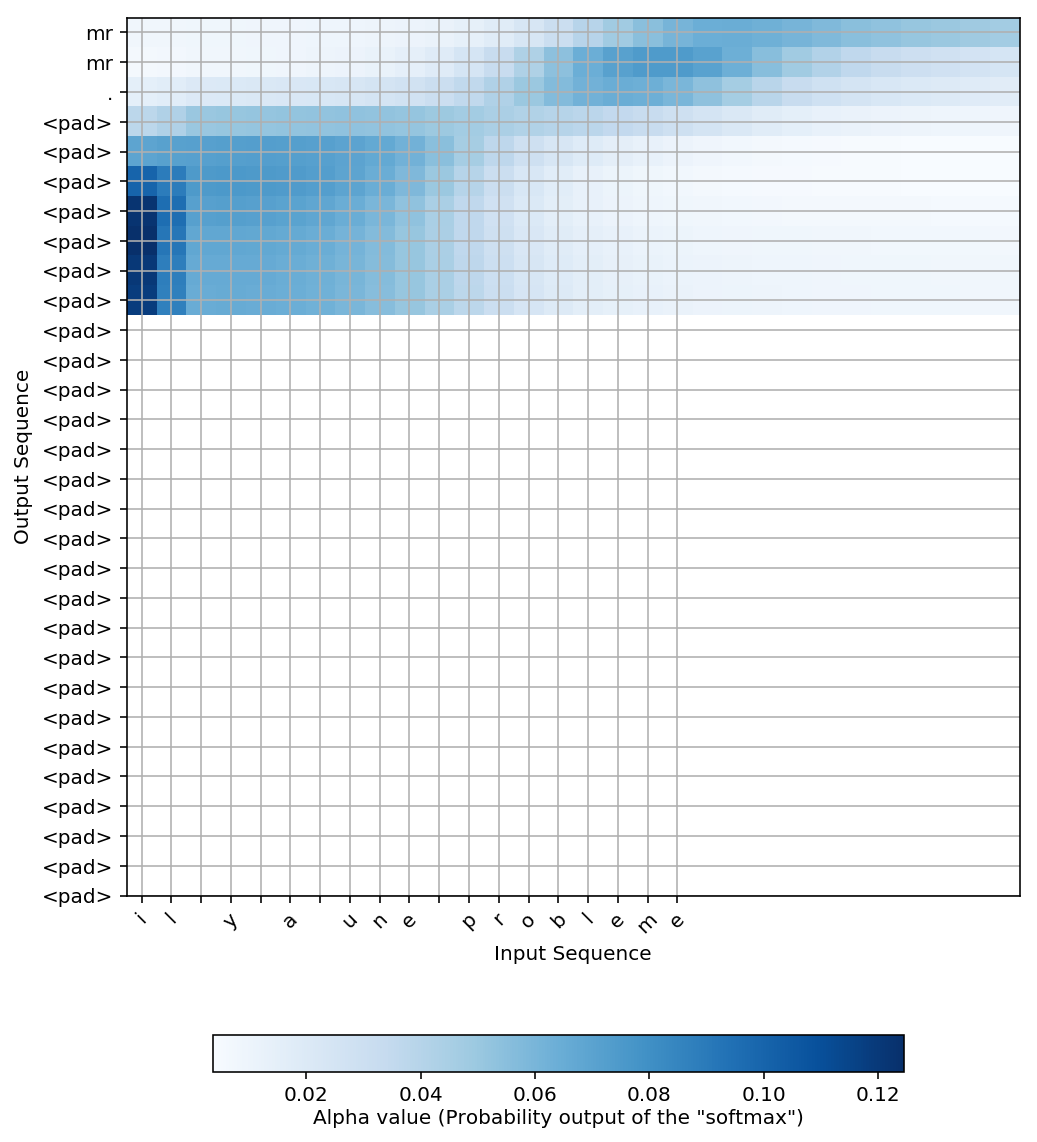

In [135]:
attention_layer = 7

attention_map = np.zeros((Ty, Tx))
    
s0 = np.zeros((1, n_s))
c0 = np.zeros((1, n_s))
layer = model.layers[attention_layer]

encoded = np.array(sentence_to_ind(new_sent, Tx, fr_2_ind)).reshape((1, Tx))
encoded = np.array(list(map(lambda x: to_categorical(x, num_classes=fr_dict_size), encoded)))

f = K.function(model.inputs, [layer.get_output_at(t) for t in range(Ty)])
r = f([encoded, s0, c0])
    
for t in range(Ty):
    for t_prime in range(Tx):
        attention_map[t][t_prime] = r[t][0,t_prime,0]

#Normalize attention map
#row_max = attention_map.max(axis=1)
#attention_map = attention_map / row_max[:, None]

prediction = model.predict([encoded, s0, c0])
    
predicted_text = []
for i in range(len(prediction)):
    predicted_text.append(int(np.argmax(prediction[i], axis=1)))
        
predicted_text = list(predicted_text)
predicted_text = int_to_string(predicted_text, ind_2_en)
    
input_length = len(new_date)
output_length = Ty

# ------------------------- Plot --------------------------------

f = plt.figure(figsize=(8, 8.5))
ax = f.add_subplot(1, 1, 1)

show_size = 10
i = ax.imshow(attention_map[0:show_size][0:show_size], interpolation='nearest', cmap='Blues')

#cbaxes = f.add_axes([0.2, 0.25, 0.6, 0.03])
cbaxes = f.add_axes([0.2, 0.1-0.01*show_size, 0.6, 0.03])
cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
cbar.ax.set_xlabel('Alpha value (Probability output of the "softmax")', labelpad=2)

ax.set_yticks(range(output_length))
ax.set_yticklabels(predicted_text[:output_length])

ax.set_xticks(range(input_length))
ax.set_xticklabels(list(new_date)[:input_length], rotation=45)

ax.set_xlabel('Input Sequence')
ax.set_ylabel('Output Sequence')

ax.grid()
f.show()

-------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------

# Sequence sampling - synthesizing music

In this program, we will train a RNN to identify musics notes. The LSTM RNN is fed with a data set (X,Y), X being a Tx = 30 time-units snippet of music notes, and Y being a sequence of the same time-length Ty = Tx of 78 possible musical notes.  

In [31]:
infile = 'data/original_metheny.mid'
#IPython.display.Audio(infile)

X, Y, n_values, indices_values, chords = load_music_utils(infile)
print('number of training examples:', X.shape[0])
print('Tx (length of sequence):', X.shape[1])
print('total # of unique values:', n_values)
print('shape of X:', X.shape)
print('Shape of Y:', Y.shape)

number of training examples: 60
Tx (length of sequence): 30
total # of unique values: 78
shape of X: (60, 30, 78)
Shape of Y: (30, 60, 78)


## Model

The model is a simple LSTM that output the an equal length sequence. It consists of a LSTM chain, and top of each LSTM block, a fully-connected layer with softmax activation to process the LSTM output.

In [32]:
n_a = 64 # number of dimensions for the hidden state of each LSTM cell.
n_values = X.shape[2] # number of music values
reshaper = Reshape((1, n_values)) 
LSTM_cell = LSTM(n_a, return_state = True)
FC = Dense(n_values, activation='softmax') 

def djmodel(Tx, n_a, n_values):

    #Arguments:
    #Tx -- length of the sequence in a corpus
    #n_a -- the number of activations used in our model
    #n_values -- number of unique values in the music data 
    
    #Returns:
    #model -- a keras instance model with n_a activations
    
   
    X = Input(shape=(Tx, n_values))
    
    
    a0 = Input(shape=(n_a,), name='a0')
    c0 = Input(shape=(n_a,), name='c0')
    a = a0
    c = c0
    
   
    outputs = []
    
    for t in range(Tx):
        
        x = Lambda(lambda X: X[:,t,:])(X)
        x = reshaper(x)
        a, _, c = LSTM_cell(inputs=x, initial_state=[a, c])
        out = FC(a)
        outputs.append(out)
        
    model = Model(inputs=[X, a0, c0], outputs=outputs)
    
    
    return model

Compile the model.

In [33]:
model = djmodel(Tx = 30 , n_a = 64, n_values = 78)
model.summary()

opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.01)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 30, 78)       0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 78)           0           input_4[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 1, 78)        0           lambda_1[0][0]                   
                                                                 lambda_2[0][0]                   
                                                                 lambda_3[0][0]                   
                                                                 lambda_4[0][0]             

Fit the model to the data (X,Y).

In [34]:
m = 60
a0 = np.zeros((m, n_a))
c0 = np.zeros((m, n_a))

model.fit([X, a0, c0], list(Y), epochs=100)

Epoch 1/100
60/60 [==============================] - 10s 164ms/step - loss: 125.9910 - dense_10_loss: 0.0000e+00 - dense_10_accuracy: 0.0000e+00 - dense_10_accuracy_1: 0.0167 - dense_10_accuracy_2: 0.0167 - dense_10_accuracy_3: 0.0333 - dense_10_accuracy_4: 0.0167 - dense_10_accuracy_5: 0.0667 - dense_10_accuracy_6: 0.0167 - dense_10_accuracy_7: 0.1167 - dense_10_accuracy_8: 0.0833 - dense_10_accuracy_9: 0.0833 - dense_10_accuracy_10: 0.0333 - dense_10_accuracy_11: 0.0500 - dense_10_accuracy_12: 0.0333 - dense_10_accuracy_13: 0.0000e+00 - dense_10_accuracy_14: 0.0667 - dense_10_accuracy_15: 0.0500 - dense_10_accuracy_16: 0.0667 - dense_10_accuracy_17: 0.0333 - dense_10_accuracy_18: 0.0333 - dense_10_accuracy_19: 0.0167 - dense_10_accuracy_20: 0.0500 - dense_10_accuracy_21: 0.0833 - dense_10_accuracy_22: 0.0667 - dense_10_accuracy_23: 0.0833 - dense_10_accuracy_24: 0.0667 - dense_10_accuracy_25: 0.0833 - dense_10_accuracy_26: 0.0333 - dense_10_accuracy_27: 0.0167 - dense_10_accuracy_28:

60/60 [==============================] - 0s 734us/step - loss: 74.9128 - dense_10_loss: 0.0000e+00 - dense_10_accuracy: 0.0667 - dense_10_accuracy_1: 0.2000 - dense_10_accuracy_2: 0.3000 - dense_10_accuracy_3: 0.1833 - dense_10_accuracy_4: 0.4000 - dense_10_accuracy_5: 0.2500 - dense_10_accuracy_6: 0.2833 - dense_10_accuracy_7: 0.2167 - dense_10_accuracy_8: 0.3167 - dense_10_accuracy_9: 0.3167 - dense_10_accuracy_10: 0.3167 - dense_10_accuracy_11: 0.2333 - dense_10_accuracy_12: 0.3500 - dense_10_accuracy_13: 0.3667 - dense_10_accuracy_14: 0.2667 - dense_10_accuracy_15: 0.3000 - dense_10_accuracy_16: 0.4000 - dense_10_accuracy_17: 0.2833 - dense_10_accuracy_18: 0.3833 - dense_10_accuracy_19: 0.3167 - dense_10_accuracy_20: 0.4000 - dense_10_accuracy_21: 0.3000 - dense_10_accuracy_22: 0.3167 - dense_10_accuracy_23: 0.3667 - dense_10_accuracy_24: 0.3000 - dense_10_accuracy_25: 0.4500 - dense_10_accuracy_26: 0.3000 - dense_10_accuracy_27: 0.3833 - dense_10_accuracy_28: 0.3833 - dense_10_acc

60/60 [==============================] - 0s 777us/step - loss: 39.2624 - dense_10_loss: 0.0000e+00 - dense_10_accuracy: 0.1000 - dense_10_accuracy_1: 0.3167 - dense_10_accuracy_2: 0.4833 - dense_10_accuracy_3: 0.3833 - dense_10_accuracy_4: 0.4833 - dense_10_accuracy_5: 0.6667 - dense_10_accuracy_6: 0.8000 - dense_10_accuracy_7: 0.7667 - dense_10_accuracy_8: 0.7667 - dense_10_accuracy_9: 0.8833 - dense_10_accuracy_10: 0.6833 - dense_10_accuracy_11: 0.8500 - dense_10_accuracy_12: 0.9333 - dense_10_accuracy_13: 0.8500 - dense_10_accuracy_14: 0.9333 - dense_10_accuracy_15: 0.8333 - dense_10_accuracy_16: 0.8667 - dense_10_accuracy_17: 0.9333 - dense_10_accuracy_18: 0.8667 - dense_10_accuracy_19: 0.9000 - dense_10_accuracy_20: 0.8667 - dense_10_accuracy_21: 0.8500 - dense_10_accuracy_22: 0.8333 - dense_10_accuracy_23: 0.8500 - dense_10_accuracy_24: 0.8167 - dense_10_accuracy_25: 0.8667 - dense_10_accuracy_26: 0.8500 - dense_10_accuracy_27: 0.8333 - dense_10_accuracy_28: 0.9000 - dense_10_acc

60/60 [==============================] - 0s 775us/step - loss: 17.9175 - dense_10_loss: 0.0000e+00 - dense_10_accuracy: 0.1000 - dense_10_accuracy_1: 0.4667 - dense_10_accuracy_2: 0.7000 - dense_10_accuracy_3: 0.8000 - dense_10_accuracy_4: 0.9000 - dense_10_accuracy_5: 0.9833 - dense_10_accuracy_6: 0.9667 - dense_10_accuracy_7: 0.9833 - dense_10_accuracy_8: 0.9833 - dense_10_accuracy_9: 1.0000 - dense_10_accuracy_10: 1.0000 - dense_10_accuracy_11: 0.9833 - dense_10_accuracy_12: 1.0000 - dense_10_accuracy_13: 1.0000 - dense_10_accuracy_14: 1.0000 - dense_10_accuracy_15: 1.0000 - dense_10_accuracy_16: 1.0000 - dense_10_accuracy_17: 1.0000 - dense_10_accuracy_18: 1.0000 - dense_10_accuracy_19: 1.0000 - dense_10_accuracy_20: 1.0000 - dense_10_accuracy_21: 1.0000 - dense_10_accuracy_22: 1.0000 - dense_10_accuracy_23: 1.0000 - dense_10_accuracy_24: 0.9833 - dense_10_accuracy_25: 0.9833 - dense_10_accuracy_26: 1.0000 - dense_10_accuracy_27: 0.9833 - dense_10_accuracy_28: 0.9833 - dense_10_acc

60/60 [==============================] - 0s 768us/step - loss: 11.1072 - dense_10_loss: 0.0000e+00 - dense_10_accuracy: 0.0667 - dense_10_accuracy_1: 0.5333 - dense_10_accuracy_2: 0.8333 - dense_10_accuracy_3: 0.9500 - dense_10_accuracy_4: 0.9833 - dense_10_accuracy_5: 0.9833 - dense_10_accuracy_6: 1.0000 - dense_10_accuracy_7: 0.9833 - dense_10_accuracy_8: 1.0000 - dense_10_accuracy_9: 1.0000 - dense_10_accuracy_10: 1.0000 - dense_10_accuracy_11: 1.0000 - dense_10_accuracy_12: 1.0000 - dense_10_accuracy_13: 1.0000 - dense_10_accuracy_14: 1.0000 - dense_10_accuracy_15: 1.0000 - dense_10_accuracy_16: 1.0000 - dense_10_accuracy_17: 1.0000 - dense_10_accuracy_18: 1.0000 - dense_10_accuracy_19: 1.0000 - dense_10_accuracy_20: 1.0000 - dense_10_accuracy_21: 1.0000 - dense_10_accuracy_22: 1.0000 - dense_10_accuracy_23: 1.0000 - dense_10_accuracy_24: 1.0000 - dense_10_accuracy_25: 0.9833 - dense_10_accuracy_26: 1.0000 - dense_10_accuracy_27: 1.0000 - dense_10_accuracy_28: 1.0000 - dense_10_acc

60/60 [==============================] - 0s 784us/step - loss: 8.9253 - dense_10_loss: 0.0000e+00 - dense_10_accuracy: 0.0667 - dense_10_accuracy_1: 0.5333 - dense_10_accuracy_2: 0.8667 - dense_10_accuracy_3: 0.9833 - dense_10_accuracy_4: 0.9833 - dense_10_accuracy_5: 1.0000 - dense_10_accuracy_6: 1.0000 - dense_10_accuracy_7: 1.0000 - dense_10_accuracy_8: 1.0000 - dense_10_accuracy_9: 1.0000 - dense_10_accuracy_10: 1.0000 - dense_10_accuracy_11: 1.0000 - dense_10_accuracy_12: 1.0000 - dense_10_accuracy_13: 1.0000 - dense_10_accuracy_14: 1.0000 - dense_10_accuracy_15: 1.0000 - dense_10_accuracy_16: 1.0000 - dense_10_accuracy_17: 1.0000 - dense_10_accuracy_18: 1.0000 - dense_10_accuracy_19: 1.0000 - dense_10_accuracy_20: 1.0000 - dense_10_accuracy_21: 1.0000 - dense_10_accuracy_22: 1.0000 - dense_10_accuracy_23: 1.0000 - dense_10_accuracy_24: 1.0000 - dense_10_accuracy_25: 1.0000 - dense_10_accuracy_26: 1.0000 - dense_10_accuracy_27: 1.0000 - dense_10_accuracy_28: 1.0000 - dense_10_accu

60/60 [==============================] - 0s 794us/step - loss: 8.2193 - dense_10_loss: 0.0000e+00 - dense_10_accuracy: 0.1000 - dense_10_accuracy_1: 0.6000 - dense_10_accuracy_2: 0.9000 - dense_10_accuracy_3: 1.0000 - dense_10_accuracy_4: 1.0000 - dense_10_accuracy_5: 1.0000 - dense_10_accuracy_6: 1.0000 - dense_10_accuracy_7: 1.0000 - dense_10_accuracy_8: 1.0000 - dense_10_accuracy_9: 1.0000 - dense_10_accuracy_10: 1.0000 - dense_10_accuracy_11: 1.0000 - dense_10_accuracy_12: 1.0000 - dense_10_accuracy_13: 1.0000 - dense_10_accuracy_14: 1.0000 - dense_10_accuracy_15: 1.0000 - dense_10_accuracy_16: 1.0000 - dense_10_accuracy_17: 1.0000 - dense_10_accuracy_18: 1.0000 - dense_10_accuracy_19: 1.0000 - dense_10_accuracy_20: 1.0000 - dense_10_accuracy_21: 1.0000 - dense_10_accuracy_22: 1.0000 - dense_10_accuracy_23: 1.0000 - dense_10_accuracy_24: 1.0000 - dense_10_accuracy_25: 1.0000 - dense_10_accuracy_26: 1.0000 - dense_10_accuracy_27: 1.0000 - dense_10_accuracy_28: 1.0000 - dense_10_accu

60/60 [==============================] - 0s 802us/step - loss: 7.6943 - dense_10_loss: 0.0000e+00 - dense_10_accuracy: 0.1000 - dense_10_accuracy_1: 0.6667 - dense_10_accuracy_2: 0.9000 - dense_10_accuracy_3: 1.0000 - dense_10_accuracy_4: 1.0000 - dense_10_accuracy_5: 1.0000 - dense_10_accuracy_6: 1.0000 - dense_10_accuracy_7: 1.0000 - dense_10_accuracy_8: 1.0000 - dense_10_accuracy_9: 1.0000 - dense_10_accuracy_10: 1.0000 - dense_10_accuracy_11: 1.0000 - dense_10_accuracy_12: 1.0000 - dense_10_accuracy_13: 1.0000 - dense_10_accuracy_14: 1.0000 - dense_10_accuracy_15: 1.0000 - dense_10_accuracy_16: 1.0000 - dense_10_accuracy_17: 1.0000 - dense_10_accuracy_18: 1.0000 - dense_10_accuracy_19: 1.0000 - dense_10_accuracy_20: 1.0000 - dense_10_accuracy_21: 1.0000 - dense_10_accuracy_22: 1.0000 - dense_10_accuracy_23: 1.0000 - dense_10_accuracy_24: 1.0000 - dense_10_accuracy_25: 1.0000 - dense_10_accuracy_26: 1.0000 - dense_10_accuracy_27: 1.0000 - dense_10_accuracy_28: 1.0000 - dense_10_accu

## Sequence sampling from the model

Now we have trained an RNN model to identify music sequence. We can sample the sequence by fitting the RNN output to itself. To be precise, for a LSTM block at t, we fit the output of the LSTM block at t-1, y(t-1), to its input x(t), and we append the output y(t) to our generated sequence. This way we can endlessly synthesize a new sequence from a trained model and some random intial (t=0) input.

Note that we have used the globally defined _LSTM&#95;cell_ and _FC_ in the layer variables. This allowed us to extract the model parameters we trained in the previous section.

In [35]:
def music_inference_model(LSTM_cell, densor, n_values = 78, n_a = 64, Ty = 100):
    
    #Arguments:
    #LSTM_cell -- the trained "LSTM_cell" from model(), Keras layer object
    #FC -- the trained dense layer from model(), Keras layer object
    #n_values -- integer, number of unique values
    #n_a -- number of units in the LSTM_cell
    #Ty -- integer, number of time steps to generate
    
    #Returns:
    #inference_model -- Keras model instance

    x0 = Input(shape=(1, n_values))
   
    a0 = Input(shape=(n_a,), name='a0')
    c0 = Input(shape=(n_a,), name='c0')
    a = a0
    c = c0
    x = x0

    outputs = []
    
    for t in range(Ty):
        
        a, _, c = LSTM_cell(inputs=x, initial_state=[a, c])
        out = FC(a)
        outputs.append(out)
        x = Lambda(lambda x: one_hot(x))(out)
        
    inference_model = Model(inputs=[x0, a0, c0], outputs=outputs)
    
    
    return inference_model

In [37]:
inference_model = music_inference_model(LSTM_cell, FC, n_values = 78, n_a = 64, Ty = 50)

inference_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 1, 78)        0                                            
__________________________________________________________________________________________________
a0 (InputLayer)                 (None, 64)           0                                            
__________________________________________________________________________________________________
c0 (InputLayer)                 (None, 64)           0                                            
__________________________________________________________________________________________________
lstm_7 (LSTM)                   [(None, 64), (None,  36608       input_5[0][0]                    
                                                                 a0[0][0]                   

Predict the sequence from our inference model. And then save it and display the sampled sequence in .mp3 format. The indices-to-tone dictionary (indices_values) and chords are needed to generate audible sequence.

In [38]:
x_initializer = np.zeros((1, 1, 78))
a_initializer = np.zeros((1, n_a))
c_initializer = np.zeros((1, n_a))

pred = inference_model.predict([x_initializer, a_initializer, c_initializer])
indices = np.argmax(pred, axis=-1)
results = to_categorical(indices, num_classes=x_initializer.shape[-1])

results, indices = predict_and_sample(inference_model, x_initializer, a_initializer, c_initializer)

In [39]:
out_filename = "./output/my_music.midi"
out_stream = generate_music(inference_model, indices_values, chords, outfile = out_filename)

mf = midi.MidiFile()
mf.open(out_filename) # path='abc.midi'
mf.read()
mf.close()
s = midi.translate.midiFileToStream(mf)
s.show('midi')

Predicting new values for different set of chords.
Generated 51 sounds using the predicted values for the set of chords ("1") and after pruning
Generated 51 sounds using the predicted values for the set of chords ("2") and after pruning
Generated 51 sounds using the predicted values for the set of chords ("3") and after pruning
Generated 51 sounds using the predicted values for the set of chords ("4") and after pruning
Generated 51 sounds using the predicted values for the set of chords ("5") and after pruning
Your generated music is saved in ./output/my_music.midi
